In [12]:
import getpass
import os
from IPython.display import Image, display

# Check if the environment variable for the OpenAI API key is not set
if not os.environ.get("OPENAI_API_KEY"):
  # Prompt the user to enter the OpenAI API key securely
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

In [13]:
import os
import sqlite3
import instructor
from openai import OpenAI
from pydantic import BaseModel, Field

## Getting Realtime queries / feedback from customer to further process the data

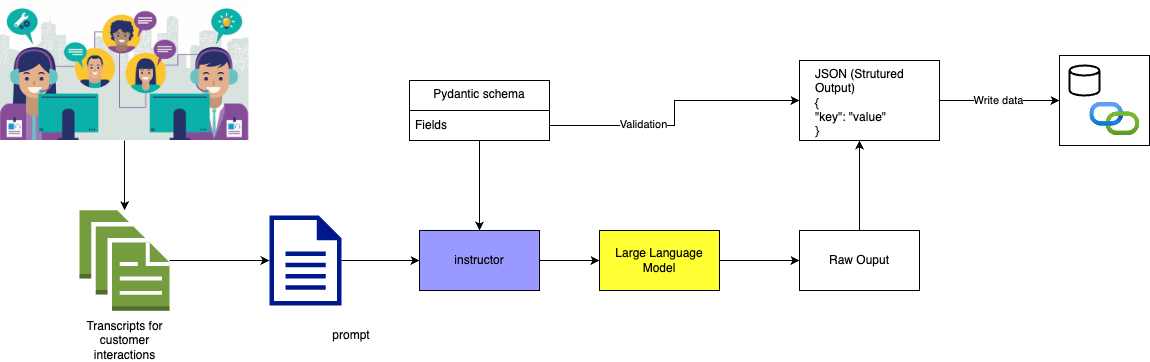

In [14]:
display(Image(filename="images/feedback.png"))

In [3]:
## MIXED REVIEW

mixed_feedback = """

**Support Agent**: Hi, Murali Anand, can you share your feedback on the product you purchased?
**User**: Sure, I am happy with the product. But, I am not satisfied with the delivery time taken. It took 5 days to deliver the product. I was expecting it to be delivered within 2 days.

**Support Agent**: I am sorry for the inconvenience caused. I will escalate this issue to the concerned team.
**User**: Thank you. I appreciate your help.

**Support Agent**: You are welcome. Is there anything else I can help you with?
**User**: No, that's it. Thank you.

**Support Agent**: Have a great day!
"""

## NEGATIVE REVIEW

negative_feedback = """

**Support Agent**: Hi, Murali Anand, can you share your feedback on the product you purchased?
**User**: I am not happy with the product I purchased. The product quality is very poor. I would like to return the product and get a refund.

**Support Agent**: I am sorry for the inconvenience caused. I will escalate this issue to the concerned team.
**User**: Thank you. I appreciate your help.

**Support Agent**: You are welcome. Is there anything else I can help you with?
**User**: No, that's it. Thank you.

**Support Agent**: Have a great day!
"""

## POSITIVE REVIEW

positive_feedback = """

**Support Agent**: Hi, Murali Anand, can you share your feedback on the product you purchased?
**User**: I am happy with the product I purchased. The product quality is very good. I would like to appreciate the support team for their help.

**Support Agent**: I am glad to hear that you are happy with the product. I will share your feedback with the support team.
**User**: Thank you.

**Support Agent**: You are welcome. Is there anything else I can help you with?
**User**: No, that's it. Thank you.

**Support Agent**: Have a great day!
"""

In [4]:
class FeedbackDetails(BaseModel):
    # The actual feedback given by the user
    user_feedback: str = Field(..., title="User Feedback", description="Actual feedback given by the user")
    
    # Summary of the user feedback
    feedback_summary: str = Field(..., title="Feedback Summary", description="Summary of the user feedback")
    
    # Type of feedback: Negative, Positive, or Mixed
    feedback_type: str = Field(..., title="Feedback Type", description="Negative or Positive or Mixed feedback")

In [5]:
def run_instructor(review: str, response_model: BaseModel):
    # Create an instructor client using the OpenAI API
    client = instructor.from_openai(OpenAI())
    
    # Generate a response using the instructor client
    return client.chat.completions.create(
        model="gpt-4o-mini",  # Specify the model to use
        response_model=response_model,  # Specify the response model
        messages=[{"role": "user", "content": review}],  # Provide the review as input
    )

In [6]:
# Generate feedback details for positive feedback using the run_instructor function
positive_feedback_details = run_instructor(positive_feedback, FeedbackDetails)

# Generate feedback details for negative feedback using the run_instructor function
negative_feedback_details = run_instructor(negative_feedback, FeedbackDetails)

# Generate feedback details for mixed feedback using the run_instructor function
mixed_feedback_details = run_instructor(mixed_feedback, FeedbackDetails)

In [7]:
def create_and_truncate_feedback_table():
    # Connect to the SQLite database (or create it if it doesn't exist)
    conn = sqlite3.connect('sample_db.db')
    cursor = conn.cursor()
    
    # Create the user_feedback table if it doesn't exist
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS user_feedback (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        user_feedback TEXT NOT NULL,
        feedback_summary TEXT NOT NULL,
        feedback_type TEXT NOT NULL,
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
    )''')
    
    # Truncate the user_feedback table
    cursor.execute('DELETE FROM user_feedback')
    
    # Commit the transaction
    conn.commit()
    
    # Close the database connection
    conn.close()

def save_feedback_to_db(feedback_details: FeedbackDetails):
    # Connect to the SQLite database (or create it if it doesn't exist)
    conn = sqlite3.connect('sample_db.db')
    cursor = conn.cursor()
    
    # Prepare the feedback details for insertion
    feedback_details_sql = (feedback_details.user_feedback, feedback_details.feedback_summary, feedback_details.feedback_type)
    
    # Insert the feedback details into the user_feedback table
    cursor.execute('INSERT INTO user_feedback (user_feedback, feedback_summary, feedback_type) VALUES (?, ?, ?)', feedback_details_sql)
    
    # Commit the transaction
    conn.commit()
    
    # Close the database connection
    conn.close()

In [8]:
# create and truncate table data if exists
create_and_truncate_feedback_table()

# Save positive feedback details to the database
save_feedback_to_db(positive_feedback_details)

# Save negative feedback details to the database
save_feedback_to_db(negative_feedback_details)

# Save mixed feedback details to the database
save_feedback_to_db(mixed_feedback_details)

In [9]:
def show_feedback_from_db():
    # Connect to the SQLite database
    conn = sqlite3.connect('sample_db.db')
    cursor = conn.cursor()
    
    # Execute a query to select all records from the user_feedback table
    cursor.execute('SELECT * FROM user_feedback')
    
    # Fetch all the results of the query
    feedback_details = cursor.fetchall()
    
    # Close the database connection
    conn.close()
    
    # Return the fetched feedback details
    return feedback_details

In [10]:
# Call the function to show feedback from the database
show_feedback_from_db()

[(1,
  'I am happy with the product I purchased. The product quality is very good. I would like to appreciate the support team for their help.',
  'User is happy with the product quality and appreciates the support team.',
  'Positive',
  '2025-02-21 17:39:53'),
 (2,
  'I am not happy with the product I purchased. The product quality is very poor. I would like to return the product and get a refund.',
  'Poor product quality and desire for a refund.',
  'Negative',
  '2025-02-21 17:39:53'),
 (3,
  'I am happy with the product. But, I am not satisfied with the delivery time taken. It took 5 days to deliver the product. I was expecting it to be delivered within 2 days.',
  'The product is good, but the delivery time was longer than expected.',
  'Mixed',
  '2025-02-21 17:39:53')]